![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# **Proyecto - Grupo 8**

Realizado por:
- Lady Tatiana Garcia Moreno
- Joaquin Abondano Araoz
- Edwin Ricardo Ramirez Calvijo
- Omar Leonardo Albarracin Monsalve

# Proyecto 1 - Predicción de popularidad en canción

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de popularidad en canción".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad-2025-12-prediccion-popularidad-en-cancion).

## Datos para la predicción de popularidad en cancion

En este proyecto se usará el conjunto de datos de datos de popularidad en canciones, donde cada observación representa una canción y se tienen variables como: duración de la canción, acusticidad y tempo, entre otras. El objetivo es predecir qué tan popular es la canción. Para más detalles puede visitar el siguiente enlace: [datos](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

## Importacion de librerias

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importación librerías
import pandas as pd
import numpy as np
import xgboost as xgb
import missingno as msno
import seaborn as sns
from math import log
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor,GradientBoostingClassifier,RandomForestClassifier,VotingRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz,DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score, f1_score,confusion_matrix,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Carga de datos

In [ ]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTrain_Spotify.csv')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTest_Spotify.csv', index_col=0)

In [ ]:
dataTraining.shape, dataTesting.shape

((79800, 21), (34200, 19))

In [ ]:
# Visualización datos de entrenamiento
dataTraining.head()

,Unnamed: 0,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,0,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,...,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,22
1,1,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,...,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,22
2,2,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,...,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,37
3,3,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,...,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,4,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,...,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,27


In [ ]:
# Visualización datos de test
dataTesting.head()

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


In [ ]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 100, index=dataTesting.index, columns=['Popularity'])

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission_file.csv', index_label='ID')
y_pred.head()

## Tratamiento de datos

In [ ]:
dataTraining=dataTraining.drop(columns=['Unnamed: 0','track_id'], axis=1)
dataTesting=dataTesting.drop(columns=['track_id'], axis=1)

In [ ]:
# Identificar variables categóricas y numéricas
categorical_features = dataTraining.select_dtypes(include=['object']).columns
numerical_features = dataTraining.select_dtypes(exclude=['object']).columns
print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)


Categorical features: Index(['artists', 'album_name', 'track_name', 'track_genre'], dtype='object')
Numerical features: Index(['duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'popularity'],
      dtype='object')


In [ ]:
# realizar label encoding de las variables categóricas
for col in categorical_features:
    le = LabelEncoder()
    le.fit(pd.concat([dataTraining[col], dataTesting[col]]))
    dataTraining[col] = le.transform(dataTraining[col])
    dataTesting[col] = le.transform(dataTesting[col])


#convertir variable explicitiva a numérica
dataTraining['explicit'] = dataTraining['explicit'].astype(int)
dataTesting['explicit'] = dataTesting['explicit'].astype(int)

In [ ]:
dataTraining.head(), dataTesting.head()

(   artists  album_name  track_name  duration_ms  explicit  danceability  \
 0    16496       22506       38845       211533         0         0.305   
 1     9501       13449        2032       196000         0         0.287   
 2    26299       35882       47203       216506         0         0.583   
 3     9841       30967       33674       218346         0         0.163   
 4    24435       32766       58262       173160         0         0.647   
 
    energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
 0  0.8490    9   -10.795     1       0.0549      0.000058          0.056700   
 1  0.1900    7   -12.030     0       0.0370      0.930000          0.000356   
 2  0.5090    1    -9.661     1       0.0362      0.777000          0.202000   
 3  0.0368    8   -23.149     1       0.0472      0.991000          0.899000   
 4  0.9210    2    -7.294     1       0.1850      0.000939          0.371000   
 
    liveness  valence    tempo  time_signature  track_genre 

**Matriz de correlacion**

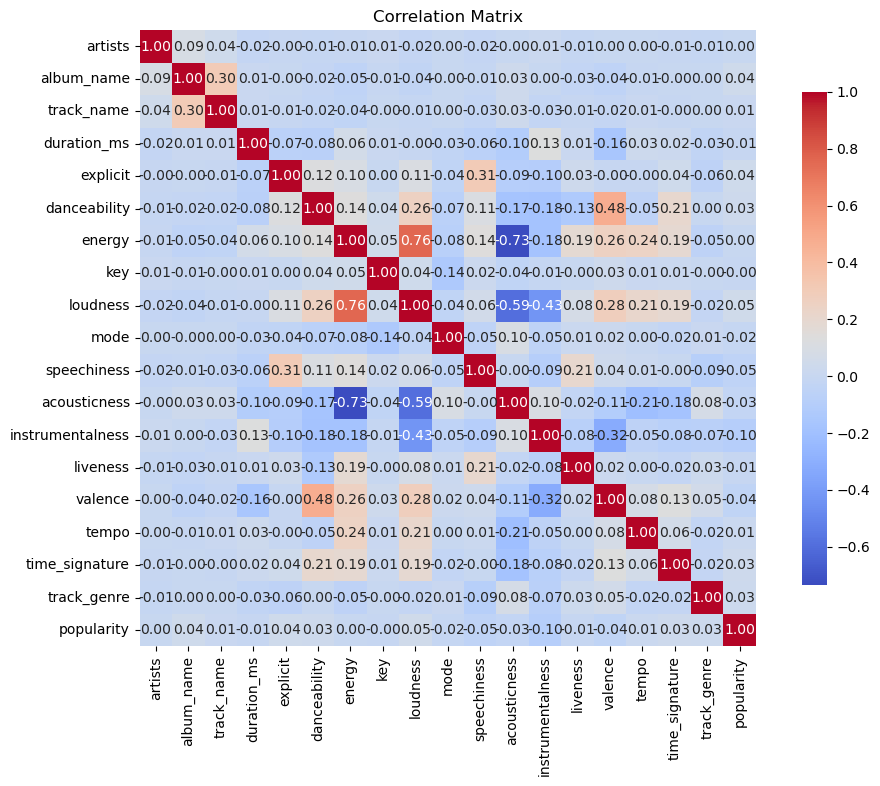

In [ ]:
correlation_matrix = dataTraining.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()

**Distribucion de las variables**

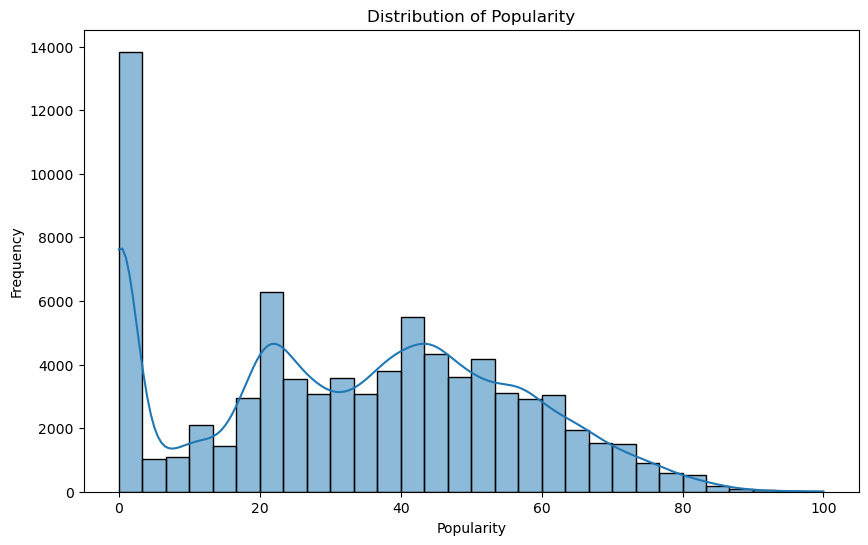

In [ ]:
# graficar la distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.histplot(dataTraining['popularity'], bins=30, kde=True)
plt.title("Distribution of Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()

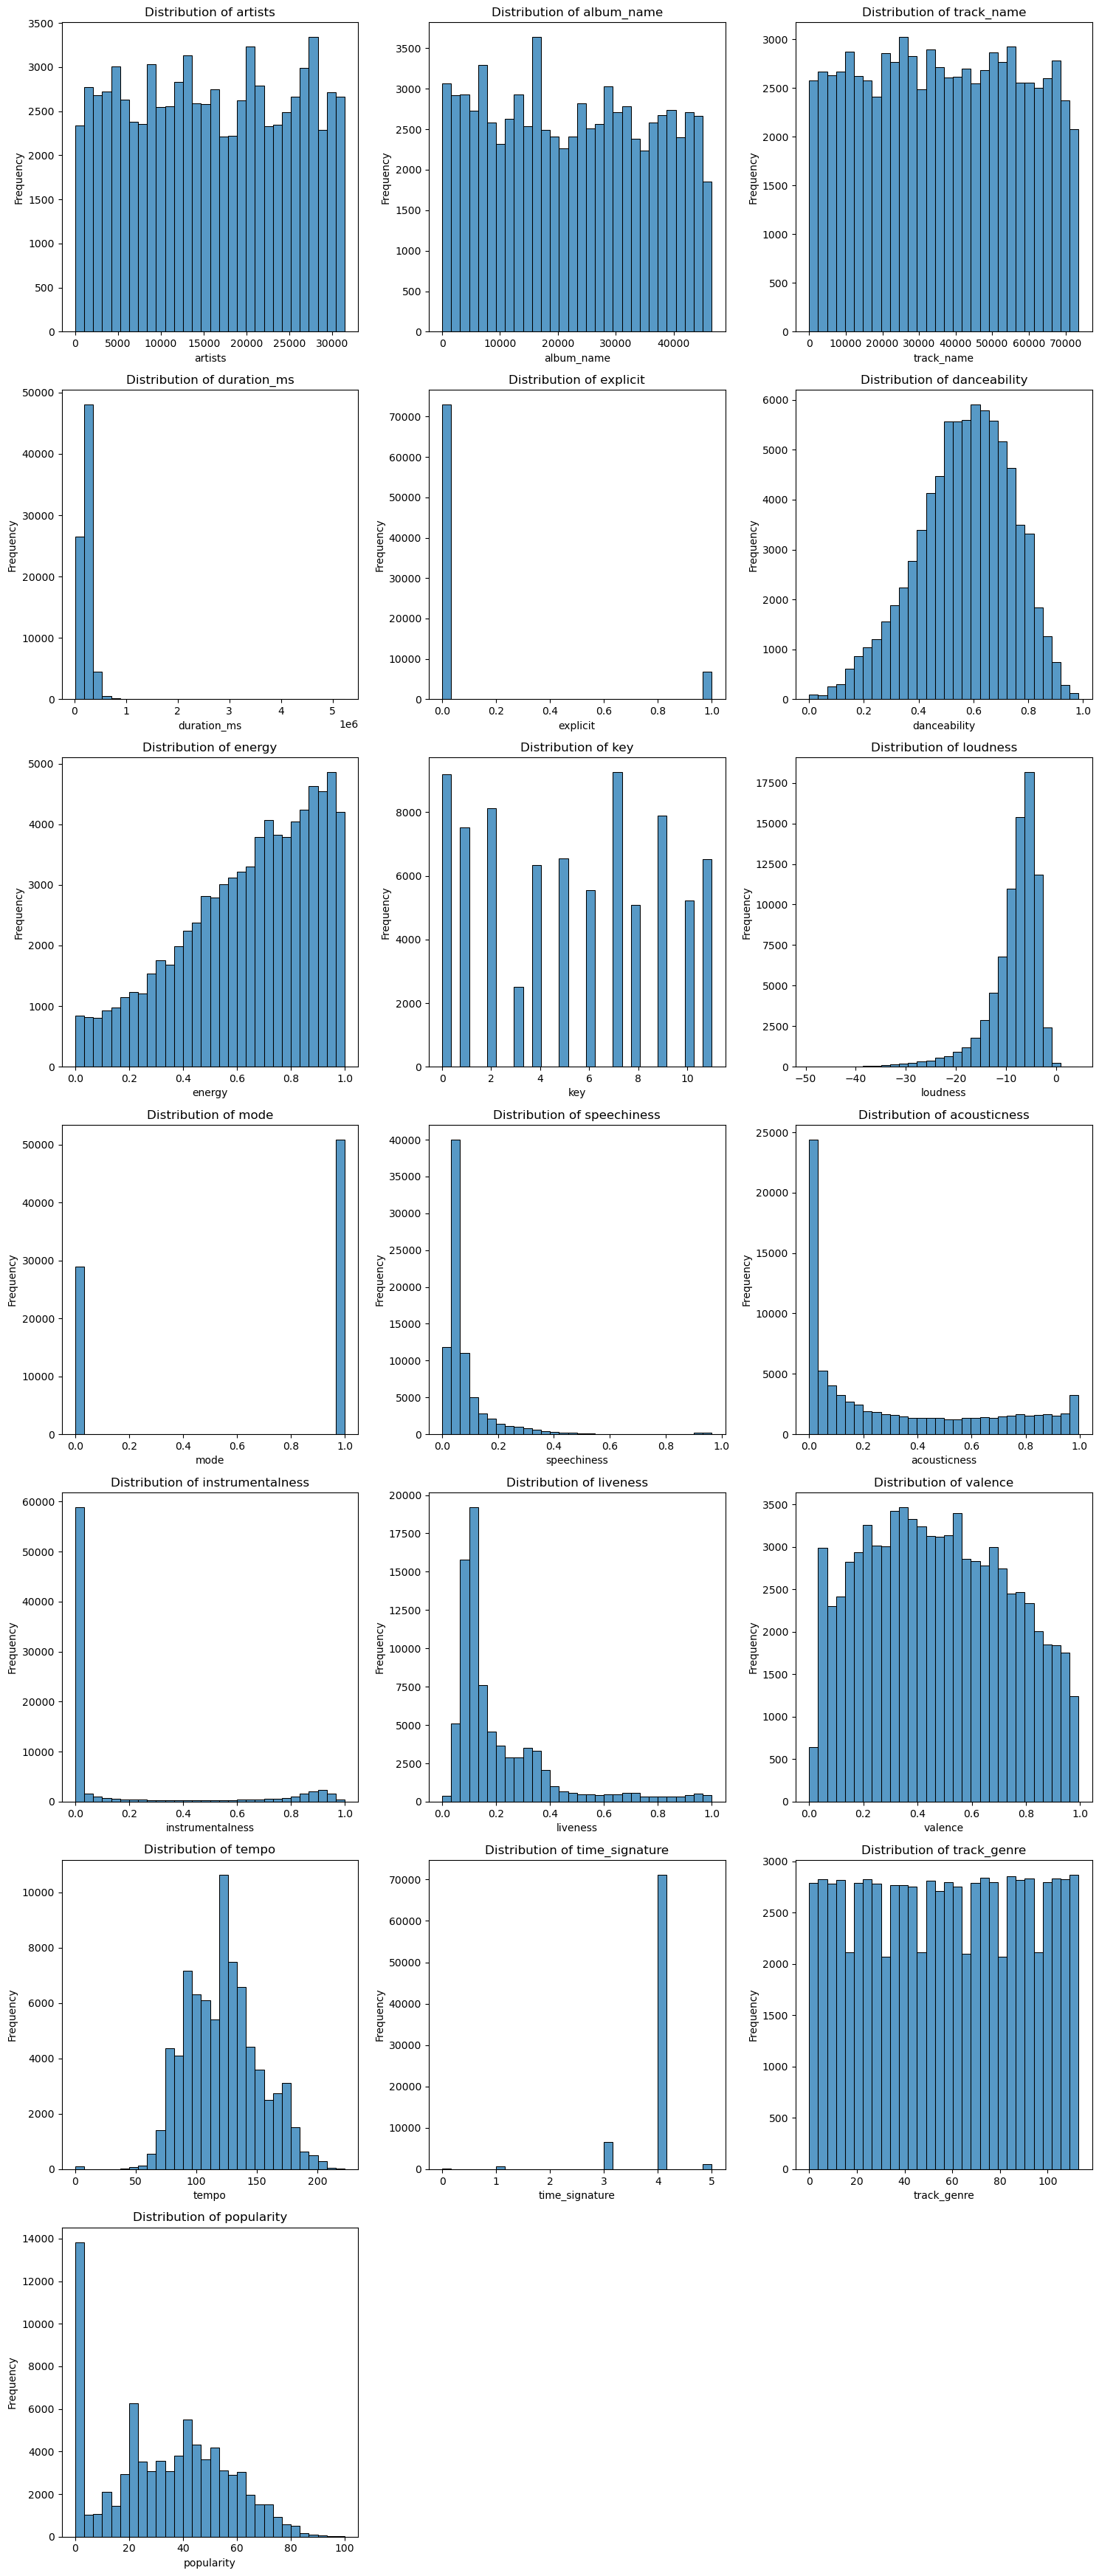

In [ ]:
# distribución de las variables numéricas
numerical_features = dataTraining.select_dtypes(exclude=['object']).columns
num_features = len(numerical_features)
rows = (num_features // 3) + (1 if num_features % 3 != 0 else 0)  # Calculate rows dynamically
plt.figure(figsize=(15, 5 * rows))
for i, col in enumerate(numerical_features):
    plt.subplot(rows, 3, i + 1)
    sns.histplot(dataTraining[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Selección de variables

**División de datos en variables predictoras (X) y variable objetivo (y)**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Definir X con las variables predictoras (sin “popularity”)
X = dataTraining.drop(columns=['popularity'], axis=1)

# 2. Definir y con la variable objetivo “popularity”
y = dataTraining['popularity']

# 3. Configurar RFE con RandomForestRegressor para seleccionar variables
selector = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=10)
selector.fit(X, y)

# 4. Extraer las variables seleccionadas por RFE
X_selected = X.loc[:, selector.support_]
X_selected_test = dataTesting.loc[:, selector.support_]

# 5. Dividir en 80 % entrenamiento y 20 % validación
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [ ]:
# from sklearn.feature_selection import RFE
# X = dataTraining.drop(columns=['popularity'], axis=1)
# y = dataTraining['popularity']
# selector = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=10)
# selector.fit(X, y)

# # Paso 2: Aplicar la máscara de selección
# X_selected = X.loc[:, selector.support_]
# X_selected_test = dataTesting.loc[:, selector.support_]
# X_selected

,artists,album_name,track_name,duration_ms,danceability,loudness,speechiness,acousticness,valence,track_genre
0,16496,22506,38845,211533,0.305,-10.795,0.0549,0.000058,0.3200,41
1,9501,13449,2032,196000,0.287,-12.030,0.0370,0.930000,0.1330,76
2,26299,35882,47203,216506,0.583,-9.661,0.0362,0.777000,0.5440,54
3,9841,30967,33674,218346,0.163,-23.149,0.0472,0.991000,0.0387,16
4,24435,32766,58262,173160,0.647,-7.294,0.1850,0.000939,0.1710,109
...,...,...,...,...,...,...,...,...,...,...
79795,1416,4462,32174,162613,0.554,-30.566,0.0502,0.915000,0.1560,76
79796,24008,39094,60644,240062,0.689,-8.200,0.0759,0.091000,0.1630,110
79797,9821,23957,27174,136306,0.629,-11.455,0.0523,0.595000,0.8800,103
79798,27396,17753,27380,216841,0.421,-15.191,0.0335,0.948000,0.1180,0


**RFE**

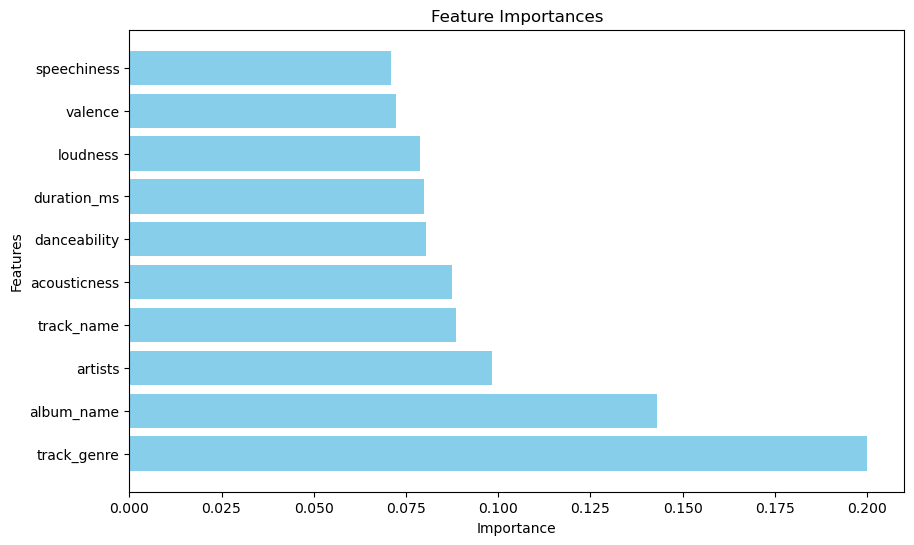

In [ ]:
feature_importances = pd.DataFrame(selector.estimator_.feature_importances_, index=X_selected.columns, columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importances.index, feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


**Visualizacion de outliers**

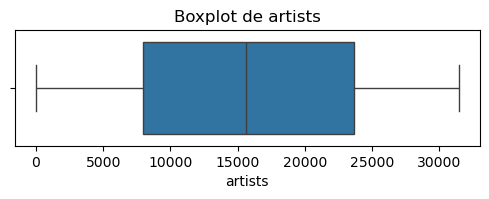

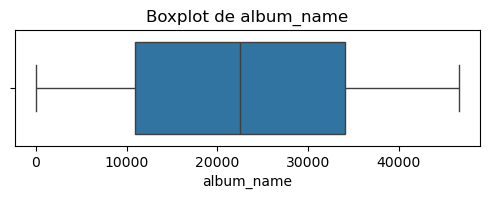

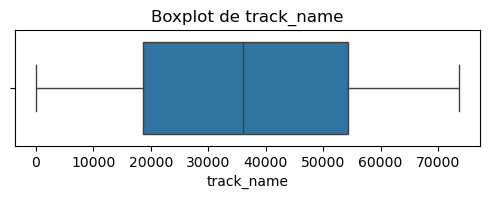

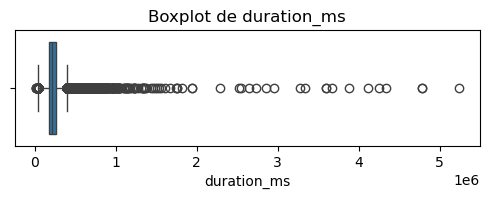

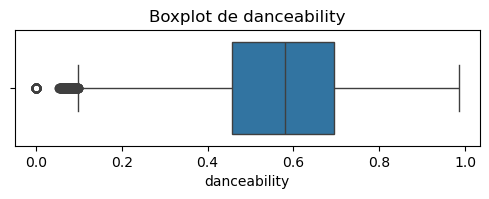

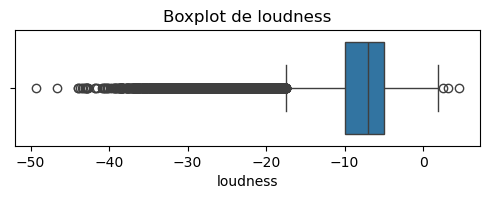

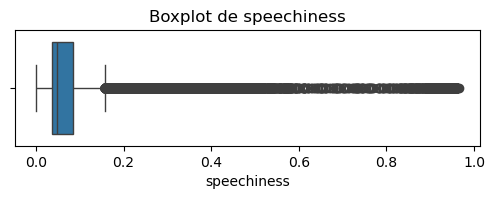

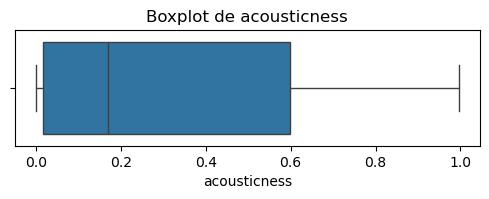

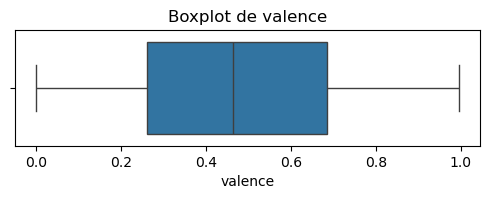

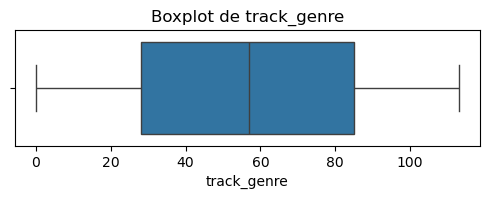

In [ ]:
for column in X_selected.columns:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=X_selected[column])
    plt.title(f'Boxplot de {column}')
    plt.show()

In [ ]:
from scipy.stats import zscore

z_scores = np.abs(zscore(X_selected))
outlier_mask = (z_scores > 3)  # 3 o más desviaciones estándar = potencial outlier
outliers = X_selected[(outlier_mask).any(axis=1)]

print(f"Filas con outliers detectados: {outliers.shape[0]}")

Filas con outliers detectados: 3853


## Entrenamiento y calibracion de modelos

### **Random forest regressor**

In [ ]:
# Definir el modelo de random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Entrenar el modelo
rf.fit(X_train, y_train)
# Realizar predicciones
y_pred = rf.predict(X_test)
# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)
# Calcular el rmse
rmse = np.sqrt(mse)
print("RMSE:", rmse)
mae=mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

Error cuadrático medio: 222.94461736118308
RMSE: 14.93133006001753
MAE: 11.05377130474997


In [ ]:
#dataTesting = scaler.transform(dataTesting)
y_pred = pd.DataFrame(rf.predict(dataTesting), index=dataTesting.index, columns=['Popularity'])
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission_filerf.csv', index_label='ID')
y_pred.head()

,Popularity
0,41.68
1,15.79
2,22.21
3,4.55
4,27.53


### **Random forest con calibración**

Mejor RMSE promedio: 15.1060 con n_estimators = 2510


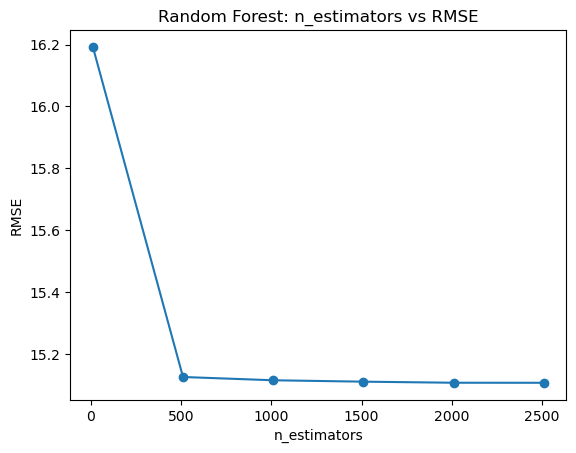

In [ ]:
# calibración de n_estimators para el modelo de random forest incluyendo cross-validation

estimator_range = range(10, 3000, 500)

# Definición de lista para almacenar r2 promedio para cada valor de n_estimators
rmse = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    score = cross_val_score(reg, X_selected, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    rmse.append(-score)  # Invertimos el signo para que sea RMSE positivo

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse, marker='o')
plt.title('Random Forest: n_estimators vs RMSE')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

#r2
mejor_rmse = min(rmse)
n_estimators = estimator_range[rmse.index(mejor_rmse)]
print(f"Mejor RMSE promedio: {mejor_rmse:.4f} con n_estimators = {n_estimators}")

Mejor RMSE promedio: 15.0960 con max_features = 8


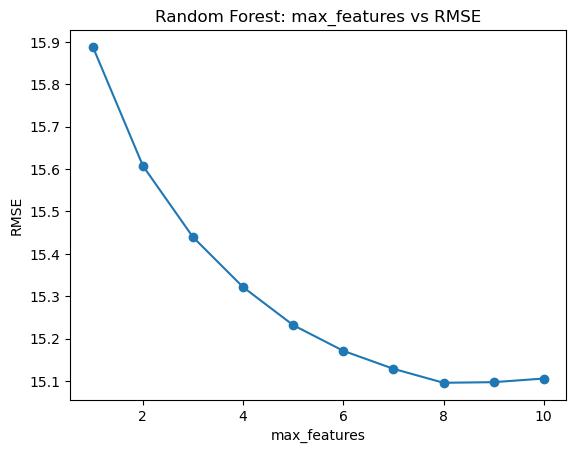

In [ ]:
range_features = range(1, X_selected.shape[1] + 1)
mse_mf_values = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in range_features:
    reg = RandomForestRegressor(n_estimators=n_estimators, max_features=feature, random_state=1, n_jobs=-1)
    score = cross_val_score(reg, X_selected, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    mse_mf_values.append(-score)  # Invertimos el signo para que sea RMSE positivo

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(range_features, mse_mf_values, marker='o')
plt.title('Random Forest: max_features vs RMSE')

plt.xlabel('max_features')
plt.ylabel('RMSE')

#r2
mejor_rmse = min(mse_mf_values)
max_features = range_features[mse_mf_values.index(mejor_rmse)]
print(f"Mejor RMSE promedio: {mejor_rmse:.4f} con max_features = {max_features}")

In [ ]:
# Rango de valores de max_depth a evaluar
range_depth = range(1, 40)  # Por ejemplo de 1 hasta 40 niveles de profundidad

mse_md_values = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in range_depth:
    reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=depth, random_state=1, n_jobs=-1)
    score = cross_val_score(reg, X_selected, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    mse_md_values.append(-score)  # Invertimos el signo para que sea RMSE positivo

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(range_depth, mse_md_values, marker='o')
plt.title('Random Forest: max_depth vs RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Buscar el mejor max_depth
mejor_rmse = min(mse_md_values)
max_depth = range_depth[mse_md_values.index(mejor_rmse)]
print(f"Mejor RMSE promedio: {mejor_rmse:.4f} con max_depth = {max_depth}")


KeyboardInterrupt: 

In [ ]:
# Definir el modelo de random forest regressor con parámetros calibrados
rf = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features,max_depth=10, random_state=42)
# Entrenar el modelo
rf.fit(X_train, y_train)
# Realizar predicciones
y_pred = rf.predict(X_test)
# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)
# Calcular el rmse
rmse = np.sqrt(mse)
print("RMSE:", rmse)
mae=mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

Error cuadrático medio: 356.61551005392647
RMSE: 18.884266203745554
MAE: 15.17661968836458


In [ ]:
y_pred = pd.DataFrame(rf.predict(dataTesting), index=dataTesting.index, columns=['Popularity'])
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission_filerf_calibrado.csv', index_label='ID')
y_pred.head()

,Popularity
0,45.215
1,15.645
2,22.835
3,4.930
4,26.170


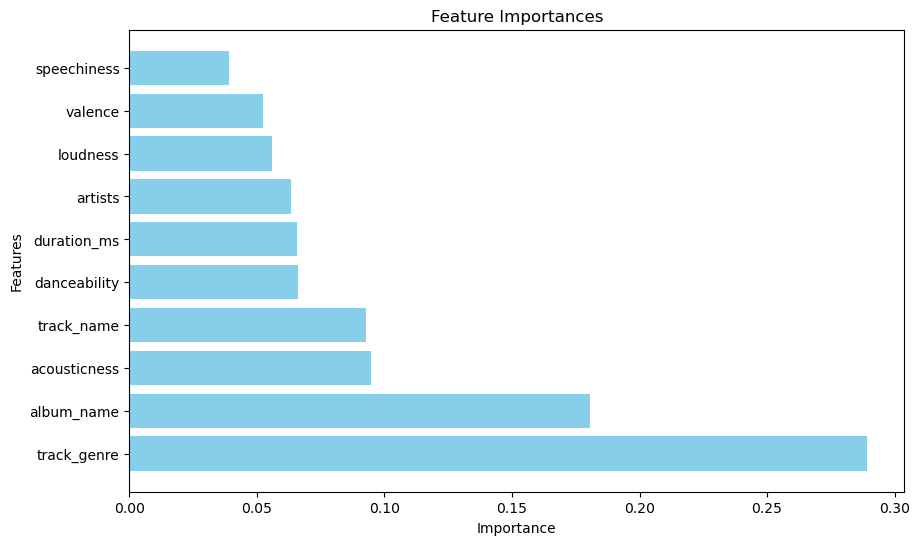

In [ ]:
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_selected.columns, columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(feature_importances.index, feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

### **Combinado random forest clasificación y regresión**

In [ ]:
# Se entrena un modelo de clasificación para predecir si la canción será popular o no (0 o 1) y otro modelo de regresión para predecir la popularidad real (0 a 100). Luego, se combinan ambos modelos para hacer la predicción final.
y_class = (y_train > 0).astype(int)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_class)

X_train_reg = X_train[y_train > 0]
y_train_reg = y_train[y_train > 0]

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_reg, y_train_reg)
# 1. Clasificar si la canción será popular
probs = clf.predict_proba(X_test)[:, 1]
y_pred_class = (probs >= 0.7).astype(int)  # Ajustar umbral

#y_pred_class = clf.predict(X_test)

# 2. Predecir popularidad para todos
y_pred_reg_all = reg.predict(X_test)

# 3. Combinar: si la clasificación dijo "no popular", predecimos 0
y_pred_final = np.where(y_pred_class == 0, 0, y_pred_reg_all)
y_pred_final = np.clip(y_pred_final, 0, 100)

# Predicción del conjunto de test
RMSE_combinado = np.sqrt(mean_squared_error(y_test, y_pred_final))
MAE_combinado = mean_absolute_error(y_test, y_pred_final)
print("Error cuadrático medio: ", RMSE_combinado)
print("Error absoluto medio: ", MAE_combinado)

Error cuadrático medio:  14.85853797434468
Error absoluto medio:  9.81160720998926


In [ ]:
# 1. Clasificar si la canción será popular o no
probs_test = clf.predict_proba(dataTesting)[:, 1]
y_pred_class_test = (probs_test >= 0.7).astype(int)

# 2. Predecir popularidad con el regresor
y_pred_reg_test = reg.predict(dataTesting)

# 3. Combinar: si no es popular, predecimos 0
y_pred_final_test = np.where(y_pred_class_test == 0, 0, y_pred_reg_test)
y_pred_final_test = np.clip(y_pred_final_test, 0, 100)  # asegurar que no se pase de escala

# 4. Crear DataFrame para exportar
y_pred_df = pd.DataFrame(y_pred_final_test, index=dataTesting.index, columns=['Popularity'])
y_pred_df.to_csv('test_submission_rf_combinadoT.csv', index_label='ID')
y_pred_df.head()


,Popularity
0,44.14
1,14.82
2,33.65
3,0.00
4,26.23


### **Random forest con sobremuestreo**

In [ ]:
from sklearn.utils import resample
# Primero aseguramos que X_selected tenga los nombres correctos
selected_columns = list(X_selected.columns)

# Ahora en dataTraining seleccionamos solo las columnas elegidas + 'popularity'
dataTraining = dataTraining[selected_columns + ['popularity']]

# 1. Separar los registros con popularity = 0 y > 0
zero_pop = dataTraining[dataTraining['popularity'] == 0]
non_zero_pop = dataTraining[dataTraining['popularity'] > 0]

# 2. Realizar oversampling de los no-cero para igualar a los ceros
non_zero_upsampled = resample(non_zero_pop,
                              replace=True,
                              n_samples=len(zero_pop),
                              random_state=42)

# 3. Combinar el conjunto balanceado
balanced_df = pd.concat([zero_pop, non_zero_upsampled])

# dividir dataset en train y test
X = balanced_df.drop(columns=['popularity'], axis=1)
y = balanced_df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo de random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Entrenar el modelo
rf.fit(X_train, y_train)
# Realizar predicciones
y_pred = rf.predict(X_test)
# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)
# Calcular el rmse
rmse = np.sqrt(mse)
print("RMSE:", rmse)
mae=mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

Error cuadrático medio: 266.0278389849485
RMSE: 16.310359866813133
MAE: 11.708931136835856


### **Random forest con submuestreo**

In [ ]:
# Primero aseguramos que X_selected tenga los nombres correctos
selected_columns = list(X_selected.columns)

# Ahora en dataTraining seleccionamos solo las columnas elegidas + 'popularity'
dataTraining = dataTraining[selected_columns + ['popularity']]

# 1. Separar los registros con popularidad 0 y > 0
zero_pop = dataTraining[dataTraining['popularity'] == 0]
non_zero_pop = dataTraining[dataTraining['popularity'] > 0]

# 2. Tomar una muestra moderada de ceros (ej: 1.5x los no ceros)
zero_sample = zero_pop.sample(n=int(len(non_zero_pop) * 1.5),replace=True, random_state=42)

# 3. Combinar para tener un dataset balanceado, pero sin exceso
balanced_df = pd.concat([zero_sample, non_zero_pop])
# dividir dataset en train y test
X = balanced_df.drop(columns=['popularity'], axis=1)
y = balanced_df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo de random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
# Entrenar el modelo
rf.fit(X_train, y_train)
# Realizar predicciones
y_pred = rf.predict(X_test)
# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse)
# Calcular el rmse
rmse = np.sqrt(mse)
print("RMSE:", rmse)
mae=mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

Error cuadrático medio: 93.44616787375301
RMSE: 9.666755809150917
MAE: 4.736500330700964


In [ ]:
y_pred = pd.DataFrame(rf.predict(dataTesting), index=dataTesting.index, columns=['Popularity'])
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission_wunders.csv', index_label='ID')
y_pred.head()

,Popularity
0,45.25
1,21.99
2,29.79
3,2.95
4,23.30


### **XGB Regressor**

In [ ]:
# Primero aseguramos que X_selected tenga los nombres correctos
selected_columns = list(X_selected.columns)

# Ahora en dataTraining seleccionamos solo las columnas elegidas + 'popularity'
dataTraining = dataTraining[selected_columns + ['popularity']]
X = dataTraining.drop(columns=['popularity'], axis=1)
y = dataTraining['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb = XGBRegressor(n_estimators=2500, learning_rate=0.020, max_depth=15, random_state=42)
xgb.fit(X_train, y_train)
y_pred_test_xgb = xgb.predict(X_test)
RMSE_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
MAE_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
print("Error cuadrático medio: ", RMSE_xgb)
print("Error absoluto medio: ", MAE_xgb)

Error cuadrático medio:  13.236997147128093
Error absoluto medio:  9.222336835226878


In [ ]:
y_pred = pd.DataFrame(xgb.predict(dataTesting), index=dataTesting.index, columns=['Popularity'])
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission_xgb.csv', index_label='ID')
y_pred.head()

,Popularity
0,48.091461
1,15.651799
2,7.080285
3,-1.542080
4,23.057699


In [ ]:
X = dataTraining.drop(columns=['popularity','time_signature','explicit','mode','key','instrumentalness'], axis=1)
y = dataTraining['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb = XGBRegressor(n_estimators=2500, learning_rate=0.02, max_depth=15, random_state=42)
xgb.fit(X_train, y_train)
y_pred_test_xgb = xgb.predict(X_test)
RMSE_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
MAE_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
print("Error cuadrático medio: ", RMSE_xgb)
print("Error absoluto medio: ", MAE_xgb)

Error cuadrático medio:  13.326662917327724
Error absoluto medio:  9.28860817021603


In [ ]:
y_pred = pd.DataFrame(xgb.predict(dataTesting), index=dataTesting.index, columns=['Popularity'])
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission_xgb.csv', index_label='ID')
y_pred.head()

### **XGB regresor aplicando log1 a variables**

In [ ]:
# Preparar los datos
X = dataTraining.drop(columns='popularity')
y = dataTraining['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros del modelo (equivalente a tu configuración previa)
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.02,
    'max_depth': 15,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'min_child_weight': 3,
    'gamma': 0.1,
    'eval_metric': 'rmse',
    'seed': 42
}

# Entrenamiento con early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=2500,
                  evals=evals,
                  early_stopping_rounds=50,
                  verbose_eval=False)

# Predicciones
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE con early stopping:", rmse)
print("MAE:", mae)


RMSE con early stopping: 13.338020576764942
MAE: 9.320048862713284


In [ ]:
# Convertir dataTesting a DMatrix
dtest_final = xgb.DMatrix(dataTesting)

# Predicción final
y_pred = pd.DataFrame(model.predict(dtest_final), index=dataTesting.index, columns=['Popularity'])

# Guardar archivo CSV para Kaggle
y_pred.to_csv('test_submission_xgb_e_s.csv', index_label='ID')
y_pred.head()


,Popularity
0,46.399940
1,14.217801
2,7.502278
3,-0.924754
4,24.860935


In [ ]:

# Preparar los datos
X = dataTraining.drop(columns='popularity')
y = dataTraining['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros del modelo (equivalente a tu configuración previa)
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 25,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'min_child_weight': 3,
    'gamma': 0.1,
    'eval_metric': 'rmse',
    'seed': 42
}

# Entrenamiento con early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=2500,
                  evals=evals,
                  early_stopping_rounds=50,
                  verbose_eval=False)

# Predicciones
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE con early stopping:", rmse)
print("MAE:", mae)



RMSE con early stopping: 14.685891450196879
MAE: 10.331301591474464


In [ ]:
# Convertir dataTesting a DMatrix
dtest_final = xgb.DMatrix(dataTesting)

# Predicción final
y_pred = pd.DataFrame(model.predict(dtest_final), index=dataTesting.index, columns=['Popularity'])

# Guardar archivo CSV para Kaggle
y_pred.to_csv('test_submission_xgb_e_s1.csv', index_label='ID')
y_pred.head()

,Popularity
0,48.438602
1,14.939609
2,4.850237
3,1.312195
4,23.199991


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
X = dataTraining.drop(columns=['popularity','time_signature','explicit','mode','key','instrumentalness'], axis=1)
y = dataTraining['popularity']


# Log para valores positivos
X['duration_ms'] = np.log1p(X['duration_ms'])
X['tempo'] = np.log1p(X['tempo'])

# Escalar loudness (tiene valores negativos)
scaler_std = StandardScaler()
X[['loudness']] = scaler_std.fit_transform(X[['loudness']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros del modelo (equivalente a tu configuración previa)
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.02,
    'max_depth': 15,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'min_child_weight': 3,
    'gamma': 0.1,
    'eval_metric': 'rmse',
    'seed': 42
}

# Entrenamiento con early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=2500,
                  evals=evals,
                  early_stopping_rounds=50,
                  verbose_eval=False)

# Predicciones
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE con early stopping:", rmse)
print("MAE:", mae)


RMSE con early stopping: 13.246590758986052
MAE: 9.279961677120738


In [ ]:
X = dataTesting.drop(columns=['time_signature','explicit','mode','key','instrumentalness'], axis=1)


# Log para valores positivos
X['duration_ms'] = np.log1p(X['duration_ms'])
X['tempo'] = np.log1p(X['tempo'])

# Escalar loudness (tiene valores negativos)
scaler_std = StandardScaler()
X[['loudness']] = scaler_std.fit_transform(X[['loudness']])

dtest_final = xgb.DMatrix(X)

# Predicción final
y_pred = pd.DataFrame(model.predict(dtest_final), index=dataTesting.index, columns=['Popularity'])

# Guardar archivo CSV para Kaggle
y_pred.to_csv('test_submission_xgb_e_s4.csv', index_label='ID')
y_pred.head()

,Popularity
0,46.552441
1,14.805410
2,1.183138
3,1.651889
4,24.117399


In [ ]:
#Creando nuevas features
X = dataTraining.drop(columns=['popularity','time_signature','explicit','mode','key','instrumentalness'], axis=1)
y = dataTraining['popularity']

# Crear nuevas features
X['energy_dance'] = X['energy'] * X['danceability']
X['valence_liveness'] = X['valence'] * X['liveness']
X['acoustic_speech'] = X['acousticness'] * X['speechiness']
X['duration_per_tempo'] = X['duration_ms'] / (X['tempo'] + 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros del modelo (equivalente a tu configuración previa)
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.02,
    'max_depth': 15,
    'reg_alpha': 0.5,
    'reg_lambda': 1,
    'min_child_weight': 3,
    'gamma': 0.1,
    'eval_metric': 'rmse',
    'seed': 42
}

# Entrenamiento con early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=2500,
                  evals=evals,
                  early_stopping_rounds=50,
                  verbose_eval=False)

# Predicciones
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE con early stopping:", rmse)
print("MAE:", mae)

RMSE con early stopping: 13.244971749802035
MAE: 9.268027443562119


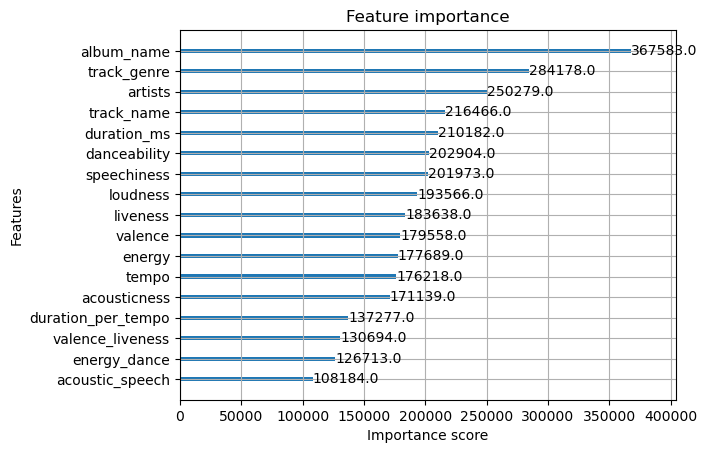

In [ ]:
xgb.plot_importance(model, max_num_features=20)
plt.show()

### **Random forest-xgboost**

In [ ]:
X = dataTraining.drop(columns=['popularity'], axis=1)
y = dataTraining['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos individuales
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=2500, learning_rate=0.02, max_depth=15, random_state=42)

# Modelo ensamblado
voting_model = VotingRegressor(
    estimators=[('rf', rf), ('xgb', xgb)]
)

# Entrenamiento
voting_model.fit(X_train, y_train)

# Predicción
y_pred = voting_model.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)


RMSE: 13.77499850804615
MAE: 10.014973775245785


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
xgb = XGBRegressor(n_estimators=2500, learning_rate=0.08, max_depth=10, random_state=42)
xgb.fit(X_train, y_train)
y_pred_test_xgb = xgb.predict(X_test)
RMSE_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
MAE_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
print("Error cuadrático medio: ", RMSE_xgb)
print("Error absoluto medio: ", MAE_xgb)

Error cuadrático medio:  12.571174188117144
Error absoluto medio:  8.790286018878932


In [ ]:
y_pred = pd.DataFrame(xgb.predict(X_selected_test), index=dataTesting.index, columns=['Popularity'])
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('selected_variables1.csv', index_label='ID')
y_pred.head()

,Popularity
0,49.114311
1,12.612198
2,3.228014
3,4.069339
4,24.014429


### **CatBoost**

In [ ]:
pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.4 MB 326.8 kB/s eta 0:05:14
   ---------------------------------------- 0.1/102.4 MB 581.0 kB/s eta 0:02:57
   ---------------------------------------- 0.2/102.4 MB 1.0 MB/s eta 0:01:42
   ---------------------------------------- 0.2/102.4 MB 1.0 MB/s eta 0:01:42
   ---------------------------------------- 0.2/102.4 MB 1.0 MB/s eta 0:01:42
   ---------------------------------------- 0.2/102.4 MB 1.0 MB/s eta 0:01:42
   ---------------------------------------- 0.2/102.4 MB 1.0 MB/s eta 0:01:42
   ---------------------------------------- 0.2/102.4 MB 1.0 MB/s eta 0:01:42
   ---------------------------------------- 0.2/102.4 MB 1.0 MB/s eta 0:01:42
   ---------------------------------------- 0.2/102.4 MB 1.0 MB/s eta 0:01:42
   

In [ ]:
# from catboost import CatBoostRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import numpy as np

# # División de datos: 80 % entrenamiento, 20 % prueba
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y,test_size=0.2,random_state=42)

# # Definición de variables categóricas
# categorical_features = ['artists', 'album_name', 'track_name', 'track_genre']

# # --- Calibración de parámetros ---
# # Ajuste de los hiperparámetros de CatBoost
# params = {
#     'iterations': 1000,           # Número máximo de árboles
#     'learning_rate': 0.01,        # Tasa de aprendizaje
#     'depth': 8,                   # Profundidad máxima de cada árbol
#     'loss_function': 'RMSE',      # Función de pérdida para regresión
#     'eval_metric': 'RMSE',        # Métrica de evaluación
#     'random_seed': 42,            # Semilla para reproducibilidad
#     'verbose': 100                # Intervalo de logs durante el entrenamiento
# }

# # Inputacion de parámetros del modelo
# catboost_model = CatBoostRegressor(**params)

# # --- Entrenamiento del modelo ---
# catboost_model.fit(X_train, y_train,cat_features=categorical_features,eval_set=(X_test, y_test),early_stopping_rounds=50)
# #
# # --- Predicción y evaluación ---
# y_pred = catboost_model.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)
# print("RMSE:", rmse)
# print("MAE:", mae)

In [ ]:
from catboost import CatBoostRegressor
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
categorical_features = ['artists', 'album_name', 'track_name', 'track_genre']

# Modelo
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

# Entrenamiento
catboost_model.fit(X_train, y_train, cat_features=categorical_features,eval_set=(X_test, y_test), early_stopping_rounds=50)

# Predicción
y_pred = catboost_model.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("RMSE:", rmse)
print("MAE:", mae)


0:	learn: 22.2163292	test: 22.0792537	best: 22.0792537 (0)	total: 266ms	remaining: 4m 26s
100:	learn: 15.0282640	test: 13.7814582	best: 13.7814582 (100)	total: 13.3s	remaining: 1m 58s
200:	learn: 13.2403705	test: 12.0710648	best: 12.0710648 (200)	total: 26.8s	remaining: 1m 46s
300:	learn: 12.4800702	test: 11.4927679	best: 11.4927679 (300)	total: 39.7s	remaining: 1m 32s
400:	learn: 12.0531193	test: 11.2115323	best: 11.2115323 (400)	total: 52.4s	remaining: 1m 18s
500:	learn: 11.8022154	test: 10.9765921	best: 10.9765921 (500)	total: 1m 12s	remaining: 1m 11s
600:	learn: 11.5857539	test: 10.7701839	best: 10.7701839 (600)	total: 1m 31s	remaining: 1m
700:	learn: 11.4275402	test: 10.6021786	best: 10.6021786 (700)	total: 1m 50s	remaining: 47s
800:	learn: 11.2951868	test: 10.4710699	best: 10.4710699 (800)	total: 2m 6s	remaining: 31.4s
900:	learn: 11.1789548	test: 10.3617553	best: 10.3617553 (900)	total: 2m 21s	remaining: 15.5s
999:	learn: 11.0640975	test: 10.2447912	best: 10.2447912 (999)	total:

In [ ]:
y_pred = pd.DataFrame(catboost_model.predict(X_selected_test), index=dataTesting.index, columns=['Popularity'])
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('selected_variablescb.csv', index_label='ID')
y_pred.head()

,Popularity
0,46.766168
1,15.419874
2,4.573266
3,-0.026793
4,24.276512
